<a href="https://colab.research.google.com/github/Jollyhrothgar/wordle/blob/main/Wordle_Solver_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Wordle is a word guessing game where the player needs to guess a five letter word. There are six chances to get the word right, and with each guess, you get information:

* Letters that are not in the word
* Letters that are in the word, but are not in the right position
* Letters thar are in the word and in the right position

One interesting feature is that the allowed guess list is much, much larger than the possible number of gueses. This introduces additional strategy, because we are not constrained by the allowed words.

## Games

* [Wordle](https://www.powerlanguage.co.uk/wordle/)
* [Lewdle](https://www.lewdlegame.com/)

# Strategy

Since the first word is a complete guess, the optimal guess is the one that obtains the most information. Some strageies:

## Guesses

Guessing a word supplies the following information:

- The word does not contain the letter at all
- The minimum number of times a letter appears in the word
- The letter exists in the word but not the position
- The letter exists in the word and not in the position
- The minimum sequential length of letters.

## Letter frequencies

Goal: try to eliminate as many letters as possible.

1. Pick a word with distinct letters
2. Choose a word that contains the most common letters
3. First guess eliminates the most uncertainty

## Letter position frequencies

Goal: try to eliminate as many positions as possible

1. Pick a word that has distinct letters, as well as most common letter positions
2. Choose word that eliminates the most position-letter pairs
3. First guess (hopefully) eliminates both a letter AND a position.

In [1]:
import urllib.request as request
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import copy
import re
import numpy as np
import functools
from IPython.display import display, clear_output, HTML

In [2]:
def load_wordlist_from_url(url):
  """Assume URL hosts a plan newline deliminated wordlist, and load to array"""
  return [line.decode("utf-8").strip().lower() for line in request.urlopen(url)]

def conjunction(*conditions):
  """Useful for combining indices, e.g. idx_1 & idx_2 & idx_3 after indices
  are created
  
  Usage: combined_idx = conjunction(*[idx1, idx2, idx3]) or conjunction(idx1, idx2, ..., idx_n)
  """
  return functools.reduce(np.logical_and, conditions)

In [3]:
guess_url = "https://gist.githubusercontent.com/cfreshman/cdcdf777450c5b5301e439061d29694c/raw/de1df631b45492e0974f7affe266ec36fed736eb/wordle-allowed-guesses.txt"
answer_url = "https://gist.githubusercontent.com/cfreshman/a03ef2cba789d8cf00c08f767e0fad7b/raw/5d752e5f0702da315298a6bb5a771586d6ff445c/wordle-answers-alphabetical.txt"

In [4]:
g_list = load_wordlist_from_url(guess_url)
a_list = load_wordlist_from_url(answer_url)
g_list = list(set(g_list + a_list))

In [5]:
class Wordle(object):
  def __init__(self, answer_list, guess_list, secret_word=None):
    self.g_list = self.make_word_df(guess_list)
    self._glist = self.make_word_df(guess_list)
    self.a_list = self.make_word_df(answer_list)
    self._a_list = self.make_word_df(answer_list)
    self.guesses = []
    self._guesses = []
    self.knowledge = {str(i+1): '?' for i in range(5)}
    self._knowledge = {str(i+1): '?' for i in range(5)}

    if secret_word is None:
      self.secret_word = self.a_list['word'].sample(1).values[0]
    else:
      self.secret_word = secret_word
      if sum(self.a_list['word'] == secret_word) == 0:
        raise ValueError(f"Secret word {secret_word} is not an option.")
    self.update_statistics()

  def snapshot_state(self):
    self._a_list = self.a_list.copy(deep=True)
    self._g_list = self.g_list.copy(deep=True) 
    self._knowledge = copy.deepcopy(self.knowledge)
    self._guesses = copy.deepcopy(self.guesses)
  
  def restore_state(self):
    self.a_list = self._a_list.copy(deep=True)
    self.g_list = self._g_list.copy(deep=True)
    self.knowledge = copy.deepcopy(self._knowledge)
    self.guesses = copy.deepcopy(self._guesses)

  @staticmethod
  def make_word_df(word_list):
    """Create a word dataframe from a list of words."""
    words = pd.DataFrame(word_list, columns=['word'])
    words['1'] = words['word'].apply(lambda x: x[0])
    words['2'] = words['word'].apply(lambda x: x[1])
    words['3'] = words['word'].apply(lambda x: x[2])
    words['4'] = words['word'].apply(lambda x: x[3])
    words['5'] = words['word'].apply(lambda x: x[4])
    return words

  @staticmethod
  def filter_letter(word_df, letter, exclude=True):
    """Apply a letter filter, by default excluding words that contain the letter"""
    if exclude:
      return word_df.loc[~word_df['word'].str.contains(letter)]
    return word_df.loc[word_df['word'].str.contains(letter)]
  
  @staticmethod
  def filter_letter_position(word_df, letter, position, exclude=True):
    """Apply a letter filter at the position level, excluding words that contain
    the letter at the specific position. When exclude is False, the inverse filter
    is applied."""
  
    if exclude:
      return word_df.loc[~(word_df[position] == letter)]
    return word_df.loc[word_df[position == letter]]

  @staticmethod
  def calculate_letter_and_position_probability(word_df):
    """Computes the probabiltiy of each letter at each position"""
    position_frequency = pd.concat(
      [
        word_df['1'].value_counts(),
        word_df['2'].value_counts(),
        word_df['3'].value_counts(),
        word_df['4'].value_counts(),
        word_df['5'].value_counts()
      ],
      axis=1
    ).fillna(0)
    return position_frequency.div(position_frequency.values.sum()).sort_index()
  
  @staticmethod
  def calculate_letter_probability(word_df):
    """Computes the probability that a letter is in the word"""
    letters = {letter: 0 for letter in 'abcdefghijklmnopqrstuvwxyz'}
    for letter in letters:
      letters[letter] = sum(word_df['word'].str.contains(letter))
    letters = pd.Series(letters)
    return letters.div(word_df.shape[0])

  @staticmethod
  def plot_statistics(joint_df, margin_df, word_count):
    fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

    sns.heatmap(joint_df, cmap='Blues', annot=True, fmt='.3f', ax=ax_l)
    ax_l.set_title(f'P(letter, position) ({word_count} words) \n $P(letter, position)$')
    margin_df.sort_values(ascending=False).plot.bar(
        title='P(word contains letter)',
        xlabel='letter',
        ylabel='probability',
        ax=ax_r
    )

  @staticmethod
  def hint_transform(hint):
    """transform a hint so that we view it's letters, mapped to positions
    and statusess.

    hint = {
      '1': ('a': 'correct'),
      '2': ('a': 'present'),
      '3': ('a': 'absent')
      ...
    }

    This is a useful transformer for cases where we guess a word with more than
    one letter, but the target word has only one of that letter.
    """
    out = {}

    for k, v in hint.items():
      if v[0] not in out:
        out[v[0]] = [v[1]]
      else:
        out[v[0]].append(v[1])
    return out
  
  def show_statistics(self):
    self.update_statistics()
    self.plot_statistics(self.letter_and_position_probability, self.letter_probability, self.a_list.shape[0])

  def update_statistics(self):
    self.letter_and_position_probability = self.calculate_letter_and_position_probability(self.a_list)
    self.letter_probability = self.calculate_letter_probability(self.a_list)

  def guess(self, guess):
    """We guess a word against a secret word, and properly calculate the
    information that is learned.
  
    To do this, we have to keep track of edge cases such as guessing too many 
    correct letters - in these cases, information is preserved, meaning that the
    number of present letters will reflect the truth.
    """
    
    hint = {}
    mask = list(self.secret_word)
  
    s_counts = collections.Counter(self.secret_word)
    guess_counter = {l:0 for l in guess}
  
    hint = {
        '1': None,
        '2': None,
        '3': None,
        '4': None,
        '5': None,
    }
  
    # Get matches
    remains = []
    for i in range(len(guess)):
      if guess[i] == self.secret_word[i]:
        hint[str(i+1)] = (guess[i], 'correct')
        guess_counter[guess[i]] += 1
      else:
        remains.append(i)
      
    # Get present / absent without overcounting present
    for i in remains:
      if guess[i] in self.secret_word and guess_counter[guess[i]] < s_counts[guess[i]]:
        guess_counter[guess[i]] += 1
        hint[str(i+1)] = (guess[i], 'present')
      elif guess[i] in self.secret_word and guess_counter[guess[i]] == s_counts[guess[i]]:
        hint[str(i+1)] = (guess[i], 'absent')
      else:
        hint[str(i+1)] = (guess[i], 'absent')
    return hint

  def filter_with_guess(self, guess, apply=False):
    """Apply guess to filter"""
    hint = self.guess(guess)
    return self.filter_with_hint(hint, apply)

  def filter_with_hint(self, hint, apply=False):
    """Apply result of guess to filter"""
    tr_hint = self.hint_transform(hint)

    pre_filter_size = self.a_list.shape[0]
    knowledge = copy.deepcopy(self.knowledge)
    bool_idx_list = []

    # First pass is needed to rule out letter searches in known positions.
    for p in hint:
      letter = hint[p][0]
      status = hint[p][1]
      if status == 'correct':
        knowledge[p] = letter
        bool_idx_list.append(self.a_list[p].str.contains(letter))

    # Here, we either:
    # 1. Know a letter is in the word (and not in the position)
    # 2. Know a letter is not in the position (and remainder of the word at all)

    # Edge case: when we guess a word that has repeated letters, and one letter
    # is correct, one will show up as correct, while the other will show up as
    # absent. In this case, we know the word contains the letter, and we also
    # know N different places that DO NOT contain the letter. This information
    # must be appropriately combined.

    # Fitler remainder word according to knowledge.
    indices = [position for position, value in knowledge.items() if value == '?']


    for p in hint:
      letter = hint[p][0]
      status = hint[p][1]
      if status == 'present': #It's in the word, not here.
        bool_idx_list.append(
          self.a_list[indices].apply(lambda x: ''.join(x), axis=1).str.contains(letter)
          & ~self.a_list[p].str.contains(letter)
        )  
      if status == 'absent':
        if letter in tr_hint and len(tr_hint[letter]) > 1:
          bool_idx_list.append(
              ~self.a_list[p].str.contains(letter)
          )
        else:
          bool_idx_list.append((
              ~self.a_list[indices]
                .apply(lambda x: ''.join(x), axis=1)
                .str
                .contains(letter)
          ))

    final_idx = conjunction(*bool_idx_list)
    tmp = self.a_list.loc[final_idx]

    post_filter_size = tmp.shape[0]

    if apply:
      self.a_list = tmp
      for k, v in knowledge.items():
        if self.knowledge[k] == '?':
          self.knowledge[k] = v
     
    return pre_filter_size - post_filter_size

  def play_game(self, n_rounds=None):
    status = 'lose'
    print("Welcome to pyWordle!")
  
    while True:
      try:

        display()
        clear_output(wait=True)


      except KeyboardInterrupt:
        print(f"Game over, you {status}!")

# Exploring / Modeling

In [ ]:
# There are 30,030,180 possible combinations of initial guesses and secret
# words.
# 
# It currently takes about 1 second to calculate five guesses. 
# output = []
# total = len(a_list) * len(g_list)
# counter = 1
# w = Wordle(answer_list=a_list, guess_list=g_list)
# for secret_word in a_list:
#   w.secret_word = secret_word
#   for guess_word in g_list:
#     if counter % 10 == 0:
#       clear_output(wait=True)
#       display(f"Progress: {counter} / {total}")
#     counter += 1
#     output.append({
#       'secret': secret_word,
#       'guess': guess_word,
#       'reduction': w.filter_with_guess(guess_word)
#     })
#     if counter >= 100:
#       break
#   if counter >= 100:
#     break

In [ ]:
# Random Search
# w = Wordle(a_list, g_list)
# global_eliminated = 0
# local_eliminated = []
# words = []
# iterations = []
# counter = 0
# plt.figure(figsize=(8, 6), dpi=100)

# while True:
#   try:
#     secret = w.a_list.sample(1)['word'].values[0]
#     guess = w.g_list.sample(1)['word'].values[0]
#     w.secret_word = secret
#     eliminated = w.filter_with_guess(guess)
#     counter += 1

#     if global_eliminated < eliminated:
#       global_eliminated = eliminated
#       local_eliminated.append(global_eliminated)
#       words.append(guess)
#       iterations.append(counter)
#       plt.plot(iterations, local_eliminated, color='red', linewidth=3)
#       plt.title(f"Iterations: {counter}, Guess: {guess}, Secret: {secret}, eliminated: {eliminated} ({100*(eliminated / w.a_list.shape[0]):.2f}%)")
#       display(plt.gcf())
#       clear_output(wait=True)
#       plt.plot(iterations, local_eliminated)
      
#   except KeyboardInterrupt:
#     print("Terminating.")
#     break



# Game Archive

Below is an archive of games I've played manually using the wordle class. In the game, I use a combination of the joint and letter frequency to get sense of what the next word I should guess is.

I try to essntially overlay the most frequent letters with the most frequent letters and positions - hopefully, by playing a few times I'll get a sense of how to turn this into a proceedure / algorithm.

## 2022-02-01

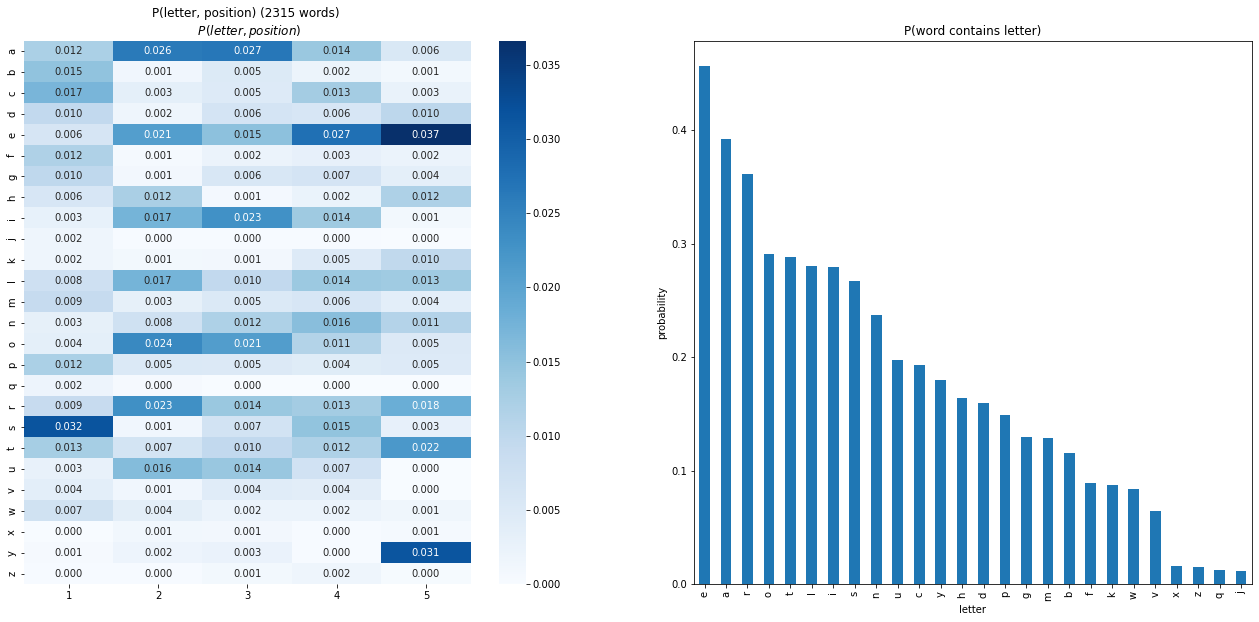

In [6]:
w = Wordle(a_list, g_list, secret_word=None)
w.show_statistics()

In [28]:
# Top 5 letters according to word frequency
top_5 = ( 
  w.letter_probability.loc[
    w.letter_probability < 1.0
  ]
  .sort_values(ascending=False)
  [:5]
)

# print(top_5)

print(
  'Possible guesses:',
  ', '.join(
    (
      w.g_list.loc[
          w.g_list['word'].str.contains('e')
        & w.g_list['word'].str.contains('a')
        & w.g_list['word'].str.contains('r')
        & w.g_list['word'].str.contains('o')
        & w.g_list['word'].str.contains('t')
      ]
    )['word'].values
  )
)



Possible guesses: orate, roate, oater


In [29]:
# guessed orate
hint = {
    '1': ('o', 'present'),
    '2': ('r', 'absent'),
    '3': ('a', 'absent'),
    '4': ('t', 'present'), 
    '5': ('e', 'correct'),
}
w.filter_with_hint(hint, apply=True)

2310

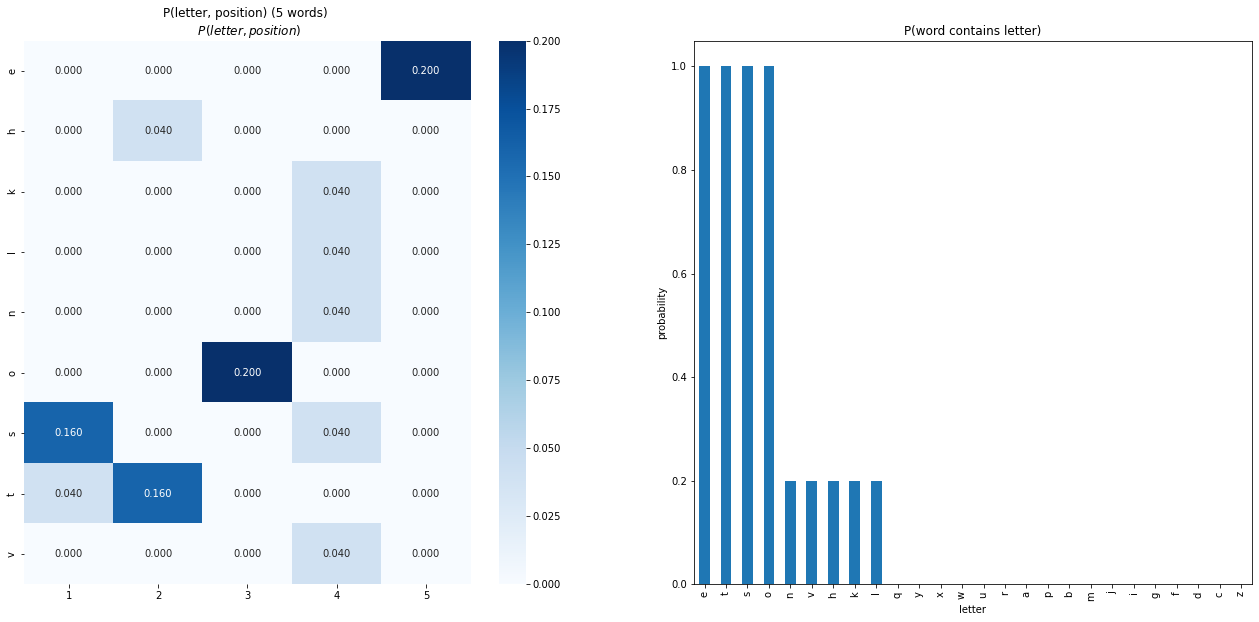

In [31]:
w.show_statistics()

In [32]:
w.a_list

,word,1,2,3,4,5
1933,stoke,s,t,o,k,e
1934,stole,s,t,o,l,e
1936,stone,s,t,o,n,e
1946,stove,s,t,o,v,e
2051,those,t,h,o,s,e


At an impass here. I think this game is a markov chain in the sense where each guess moves you into a different word-space. The only way to guarantee a solution in a minimum of guesses is to leave only one option to choose. Although our hint tells us that the word contains `o`, `t`, and `e`, we actually know that the word must also contain `s`.

So, realistically, we now just need to figure out what the remaining letters are. We have `n`, `v`, `h`, `k` and `l`, which at this point are all equally likely.

One open question is whether or not we can use the intial probabilities now to order our guess. We know that a word was chosen at random, and that not all letters were equally likely. But now, we know the full word list of options.

I guess the idea here is that there is a **prior** associated with these letters - they did not have an equal chance of being selected. So, we can order these letters according to the prior.

To test this, we look at the overall likelihood of letters in the word list.

The order is: `l`, `n`, `h`, `k`, `v`.

By this logic, if we want to try and get lucky, we should choose `stole`.

The "safe" route would be to choose a word that contains as many of these unknown letters as possible. Lets try that.

In [35]:
print(
  'Possible guesses:',
  ', '.join(
    (
      w.g_list.loc[
          w.g_list['word'].str.contains('l')
        & w.g_list['word'].str.contains('n')
        & w.g_list['word'].str.contains('h')
        # & w.g_list['word'].str.contains('k')
        # & w.g_list['word'].str.contains('v')
      ]
    )['word'].values
  )
)


Possible guesses: lunch, shuln, nahal, uhlan, lohan, nihil, lanch, linch, lynch, holon, halon


Since we know that the word probably has s in it, and we also know it's probably in position `1`, lets confirm that by guessing `shuln`.

In [37]:
# Guessed shuln
hint = {
    '1': ('s', 'present'),
    '2': ('h', 'correct'),
    '3': ('u', 'absent'),
    '4': ('l', 'absent'), 
    '5': ('n', 'absent'),
}

print(w.filter_with_hint(hint, apply=True))
w.a_list

4


,word,1,2,3,4,5
2051,those,t,h,o,s,e


## 2022-01-31

In [ ]:
w = Wordle(a_list, g_list, secret_word=None)

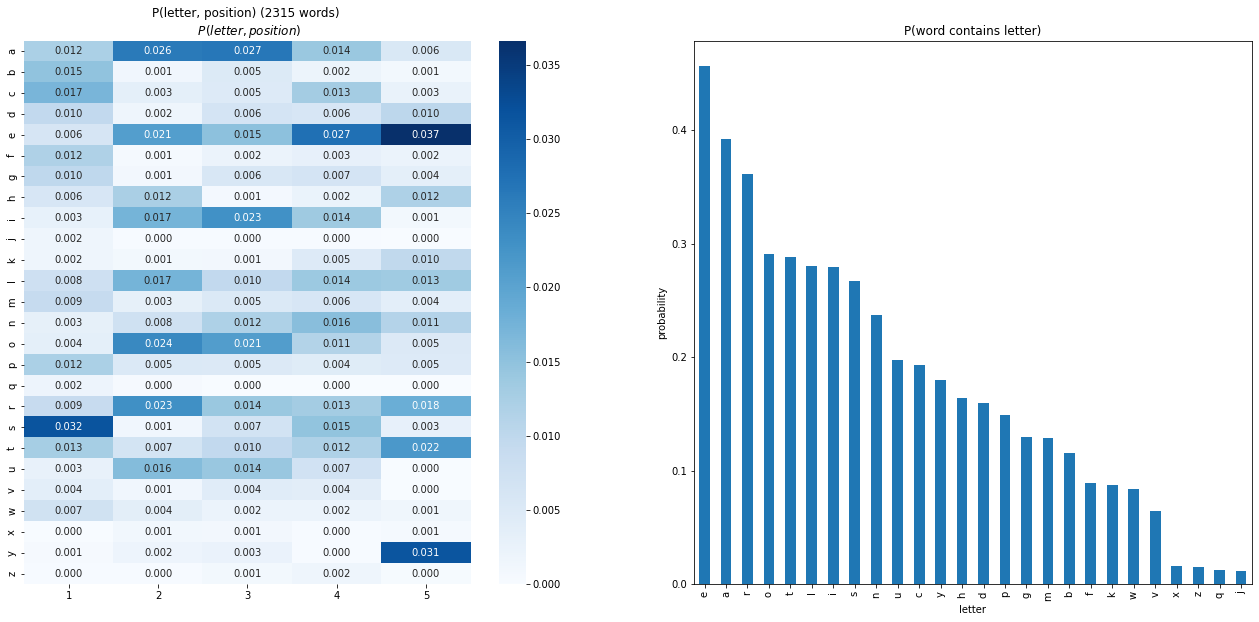

In [ ]:
w.show_statistics()

In [ ]:
hint = {
    '1': ('t', 'present'),
    '2': ('r', 'absent'),
    '3': ('i', 'present'),
    '4': ('e', 'absent'), 
    '5': ('s', 'absent'),
}
w.filter_with_hint(hint, apply=True)

2268

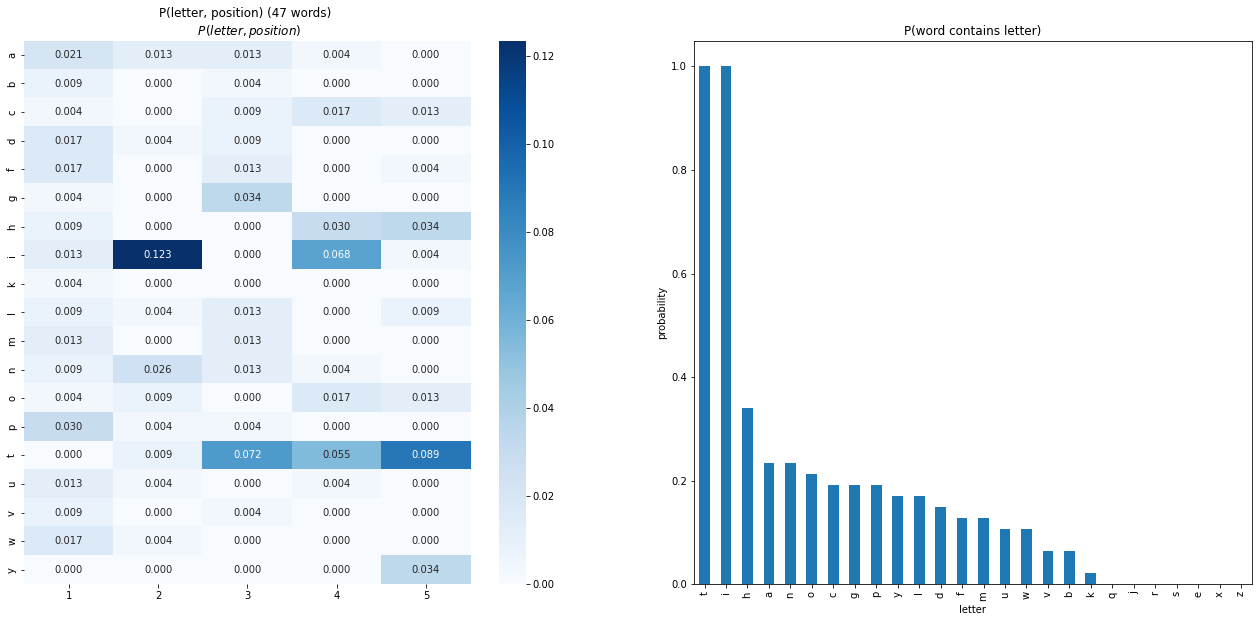

In [ ]:
w.show_statistics()

In [ ]:
# Although h is very common in the remaining words, it is only moderately likely
# to be present as one of the last two letters.
#
# Conversely, i is very likely to be in the second position. Because we already
# know that the word contains both t and i, we should not guess them.
#
# So, lets guess h, a, n, o, c, g.
# We have to make a trade-off between g and c, but because the joint probability
# of letter, and position is more confident in the position of g, we'll pick it.
#
# Alg: pick the letters to rule out, and associate with a weight of some kind
# Alg: pick letters which have the most weight and exist in the guess list.
w.g_list[
  w.g_list['word'].str.contains('h')
  & w.g_list['word'].str.contains('a')
  & w.g_list['word'].str.contains('n')
  & w.g_list['word'].str.contains('g')
  & w.g_list['word'].str.contains('o')
]

,word,1,2,3,4,5
761,hogan,h,o,g,a,n


In [ ]:
hint = {
    '1': ('h', 'present'),
    '2': ('o', 'absent'),
    '3': ('g', 'correct'),
    '4': ('a', 'absent'), 
    '5': ('n', 'absent'),
}
w.filter_with_hint(hint, apply=True)

43

In [ ]:
w.a_list

,word,1,2,3,4,5
733,fight,f,i,g,h,t
1130,light,l,i,g,h,t
1230,might,m,i,g,h,t
2268,wight,w,i,g,h,t


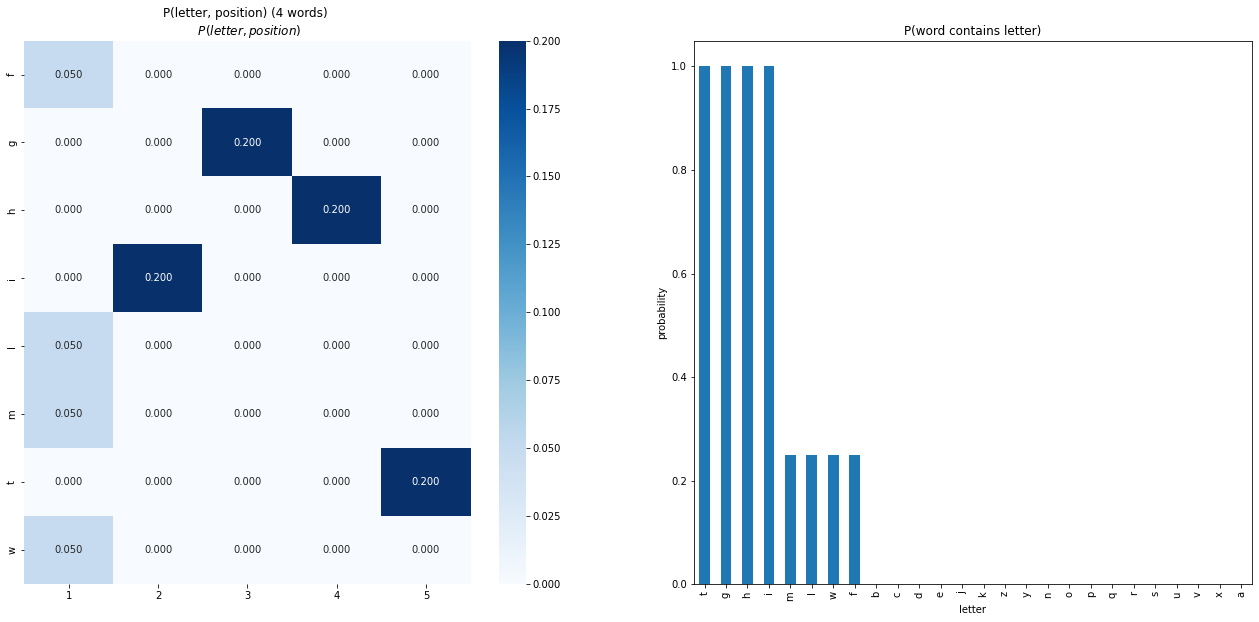

In [ ]:
w.show_statistics()

We now know there are exactly four possible words left to guess. Since they are all equally likely, I'll go with the word that was most likely to be selected to begin with - the unknown letter is in the set `(f, l, m, w)`.

My guess order will be `l`, then `m`, then `f`, then finally `w`.

## Distant Past...

In [ ]:
w = Wordle(answer_list=a_list, guess_list=g_list, secret_word=None)

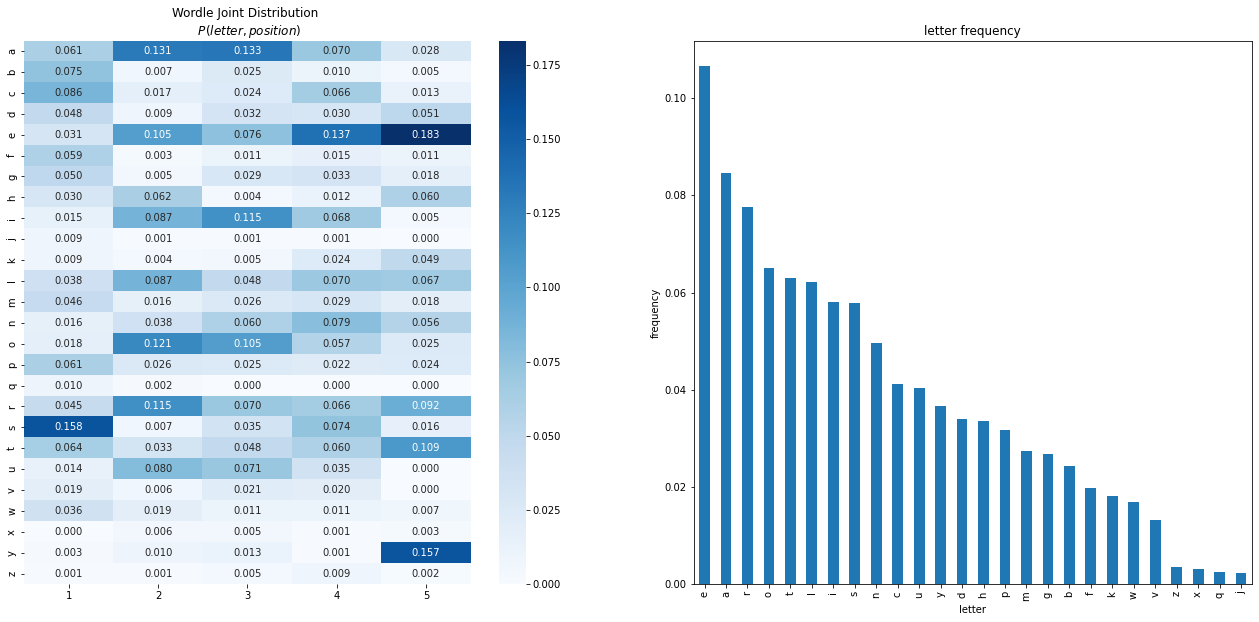

In [ ]:
w.show_statistics()

In [ ]:
hint = {
    '1': ('r','absent'),
    '2': ('e','absent'),
    '3': ('a','absent'),
    '4': ('m','absent'),
    '5': ('s','absent'),
}

In [ ]:
w.filter_with_hint(hint, apply=True)

0

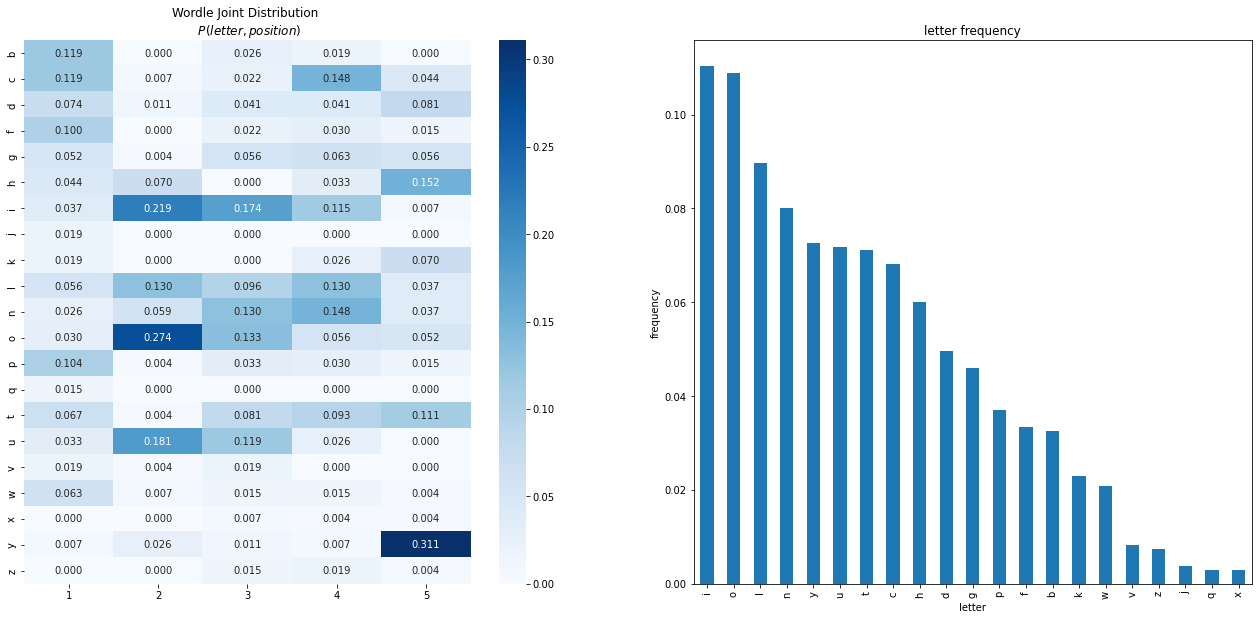

In [ ]:
w.show_statistics()

In [ ]:
w.g_list[(w.g_list['5'] == 'y') & (w.g_list['2'] =='o') & (w.g_list['3']=='i')]

,word,1,2,3,4,5
3789,roily,r,o,i,l,y
4963,noisy,n,o,i,s,y
10557,noily,n,o,i,l,y
10704,soily,s,o,i,l,y
11954,doily,d,o,i,l,y


In [ ]:
hint = {
    '1': ('d','present'),
    '2': ('o','correct'),
    '3': ('i','absent'),
    '4': ('l','correct'),
    '5': ('y','absent'),
}

In [ ]:
w.filter_with_hint(hint, apply=True)

268

In [ ]:
w.a_list

,word,1,2,3,4,5
445,could,c,o,u,l,d
2291,would,w,o,u,l,d


Secret word was could! (guesed right!)


# Game Simulator